In [1]:
import sys
sys.path.append('/scratch/programming/pipeline/pipeline')
from pipeline.Controllers.SqlController import SqlController
from pipeline.Controllers.MarkedCellController import MarkedCellController
from model.annotation_points import CellSources,MarkedCell
from atlas.Assembler import get_assembled_atlas_v7
import plotly.graph_objects as go
import numpy as np
from Plotter.Plotter import Plotter
import matplotlib.pyplot as plt
animal = 'DK41'
controller = SqlController(animal)
# cell_controller = MarkedCellController()
resolution = controller.get_resolution(animal)
# cells = cell_controller.get_marked_cells(search_dictionary = dict(id = 3586))
# # cells = cells*resolution
# bin_voxel = [500,500,500]
# bins = []
# for i,stepi in enumerate(bin_voxel):
#     axis_max = cells.max(axis=0)[i]
#     axis_bins = list(range(0,int(axis_max)+1,stepi))
#     bins.append(axis_bins)
# count,bins =np.histogramdd(cells,bins = bins)

assenbler  = get_assembled_atlas_v7()
import numpy as np
import os
from atlas.Atlas import Atlas
from pipeline.Controllers.SqlController import SqlController
from atlas.NgSegmentMaker import NgConverter
from atlas.Assembler import Assembler,get_v7_volume_and_origin,get_assembled_atlas_v7
def hist3d(data):
    origin = np.min(data,axis = 1).astype(int)
    end = np.max(data,axis = 1).astype(int)+1
    data = data - np.min(data,axis = 1).reshape(-1,1)
    shape = np.max(data,axis = 1).astype(int)
    density = np.zeros(shape)
    npoints = data.shape[1]
    for i in range(npoints):
        point = data[:,i].astype(int)-1
        density[point[0],point[1],point[2]] += 1
    return density,origin,end        

No histology for Atlas
No histology for Atlas
Shape of downsampled atlas volume (859, 700, 304)


In [2]:
controller = SqlController('DK39')
atlas = Atlas(atlas = 'atlasV7')
atlas.get_com_array()
assembler = Assembler(check=False,side = '_R')
assembler.volumes,assembler.origins = get_v7_volume_and_origin()
assembler.sqlController = atlas.sqlController
assembler.structures = list(assembler.volumes.keys())
segment_to_id = controller.get_segment_to_id_where_segment_are_brain_regions()
for i in segment_to_id:
    segment_to_id[i]=1
assembler.assemble_all_structure_volume(segment_to_id)

No histology for Atlas
No histology for Atlas
Shape of downsampled atlas volume (859, 700, 304)


In [2]:
from cell_extractor.CellDetectorBase import CellDetectorBase
animal = 'DK41'
base = CellDetectorBase(animal,round = 2)
detections = base.load_detections()
sure = detections[detections.predictions==2]
sure = np.array([sure.col,sure.row,sure.section])
sure.shape
sure = detections[detections.predictions==2]
unsure = detections[detections.predictions==0]
downsample_factor = 32
# bin_voxel = [500,500,500]
# bins = []
# for i,stepi in enumerate(bin_voxel):
#     axis_max = sure.max(axis=0)[i]
#     axis_bins = list(range(0,int(axis_max)+1,stepi))
#     bins.append(axis_bins)
# count,bins =np.histogramdd(sure,bins = bins)

In [3]:
data = sure[sure.section==180]
data = (np.array([data.col,data.row,data.section]))*np.array([0.325,0.325,20]).reshape(-1,1)  #.astype(int)

No histology for Atlas


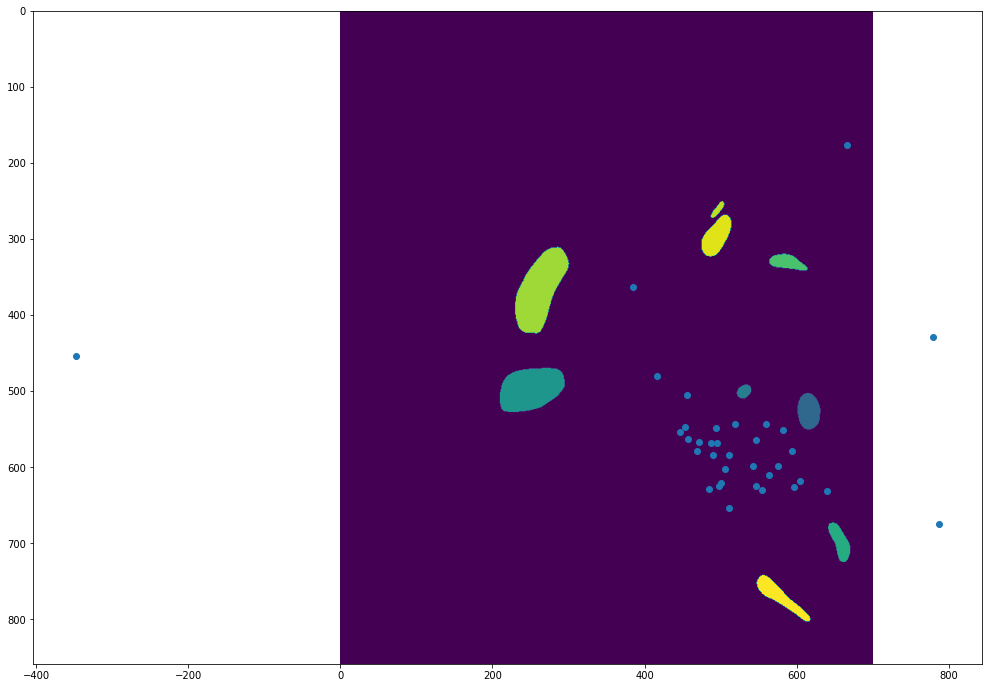

In [4]:
from pipeline.Controllers.SqlController import SqlController
import pickle
from Plotter.Plotter import Plotter
import numpy as np
from pipeline.lib.Transformation import Transformation
import SimpleITK as sitk
section = 200
data = sure[sure.section==section]
data = (np.array([data.col,data.row,data.section]))*np.array([0.325,0.325,20]).reshape(-1,1)  #.astype(int)
source = 'DK41'
destination = 'Atlas'
plotter = Plotter()
controller = SqlController('Atlas')
transformation = controller.get_transformation_row(source = source,destination = destination, transformation_type = 'Similarity')
rigid_transform = pickle.loads(transformation.transformation)
tfdata = rigid_transform.forward_transform_points(data.T).T/np.array([10,10,20]).reshape(-1,1)
plt.figure(figsize=(np.array(assenbler.combined_volume.shape[:2])/50).astype(int))
plt.imshow(assenbler.combined_volume[:,:,section])
plt.scatter(tfdata[0],tfdata[1])

In [10]:
from scipy.ndimage import zoom
test = zoom(assenbler.combined_volume, (0.1, 0.1, 0.1))
test.shape

(86, 70, 30)

In [ ]:
shape = test.shape
volume = test
X, Y, Z = eval(f'np.mgrid[  0:{shape[0]/2}:{shape[0]}j, \
                            0:{shape[1]/2}:{shape[1]}j, \
                            0:{shape[2]}:{shape[2]}j]')
data = sure
data = (np.array([data.col,data.row,data.section]))*np.array([0.325,0.325,20]).reshape(-1,1)  #.astype(int)
source = 'DK41'
destination = 'Atlas'
plotter = Plotter()
controller = SqlController('Atlas')
transformation = controller.get_transformation_row(source = source,destination = destination, transformation_type = 'Similarity')
rigid_transform = pickle.loads(transformation.transformation)
tfdata = rigid_transform.forward_transform_points(data.T).T/np.array([10,10,20]).reshape(-1,1)
data = []
dsfdata = tfdata*0.1*np.array([0.5,0.5,1]).reshape(-1,1)
data.append(go.Scatter3d(x=dsfdata[0], y=dsfdata[1], z=dsfdata[2],marker=dict(size=5,opacity=0.8),
                                   mode='markers'))
data.append(go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=volume.flatten(),
    isomin=1,
    isomax=40,
    opacity=0.5, # needs to be small to see through all surfaces
    surface_count=2, # needs to be a large number for good volume rendering
    ))
fig = go.Figure(data=data)
fig['layout']['scene']['aspectmode'] = "data"
# fig.show()
fig.write_html("/net/birdstore/Active_Atlas_Data/atlas.html")

In [62]:
def plot_3d_volume(volume,X,Y,Z,*args,**kwargs):
    shape = volume.shape
    source = 'DK41'
    destination = 'Atlas'
    plotter = Plotter()
    controller = SqlController('Atlas')
    transformation = controller.get_transformation_row(source = source,destination = destination, transformation_type = 'Similarity')
    rigid_transform = pickle.loads(transformation.transformation)
    return go.Volume(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        value=volume.flatten(),
        *args,**kwargs,
        )

In [67]:
data = sure
data = (np.array([data.col,data.row,data.section]))*np.array([0.325,0.325,20]).reshape(-1,1)
tfdata = rigid_transform.forward_transform_points(data.T).T/np.array([10,10,20]).reshape(-1,1)
tfdata = tfdata*0.1*np.array([1,1,2]).reshape(-1,1)
density,origin,end = hist3d(tfdata)
shape = test.shape
X, Y, Z = eval(f'np.mgrid[  0:{shape[0]}:{shape[0]}j, \
                                0:{shape[1]}:{shape[1]}j, \
                                0:{shape[2]*2}:{shape[2]}j]')
p1 = plot_3d_volume(test,X, Y, Z,isomin=1,
        isomax=40,
        opacity=0.5, 
        surface_count=2, opacityscale="min",)
shape = density.shape
X, Y, Z = eval(f'np.mgrid[  {origin[0]}:{end[0]}:{shape[0]}j, \
                                {origin[1]}:{end[1]}:{shape[1]}j, \
                                {origin[2]}:{end[2]}:{shape[2]}j]')
p2 = plot_3d_volume(density,X, Y, Z,isomin=1,
        isomax=20,
        opacity=0.5, 
        surface_count=20, )
data = []
data.append(p1)
# data.append(p2)
data.append(go.Scatter3d(x=tfdata[0], y=tfdata[1], z=tfdata[2],marker=dict(size=5,opacity=0.2),
                                   mode='markers'))
fig = go.Figure(data=data)
fig['layout']['scene']['aspectmode'] = "data"
fig.update_layout(scene_aspectmode="data", 
                  scene_camera_eye=dict (x=1, y=1, z=1))
fig.write_html("/net/birdstore/Active_Atlas_Data/atlas.html")

No histology for Atlas
No histology for Atlas


In [41]:
npoints = tfdata.shape[1]
category = np.ones(npoints)*-1
for i in range(npoints):
    pointi = tfdata[:,i].astype(int)-1
    if np.all(pointi>0) and np.all(pointi<test.shape):
        category[i] = test[pointi[0],pointi[1],pointi[2]]

In [54]:
segment_to_id = controller.get_segment_to_id_where_segment_are_brain_regions()
id_to_structure = {}
ids = list(segment_to_id.values())
structures = list(segment_to_id.keys())
for i,id in enumerate(np.unique(ids)):
    structure = structures[i]
    if '_' in structure:
        structure = structure.split('_')[0]
    id_to_structure[id] = structure


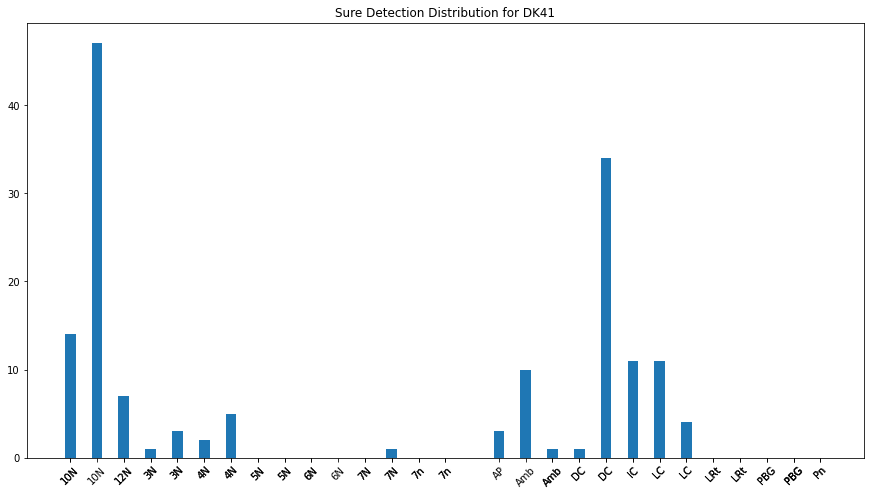

In [60]:
plt.figure(figsize = [15,8])
counts=[]
for i in ids:
    counts.append(sum(category==i))
structures = [id_to_structure[i] for i in ids]
plt.title('Sure Detection Distribution for DK41')
plt.bar(ids,counts, width = 0.4);
plt.xticks(ids, structures, rotation=45);

In [22]:
data = sure
data = (np.array([data.col,data.row,data.section]))*np.array([0.325,0.325,20]).reshape(-1,1)
tfdata = rigid_transform.forward_transform_points(data.T).T/np.array([10,10,20]).reshape(-1,1)
tfdata = tfdata*0.1*np.array([1,1,2]).reshape(-1,1)
tfdata.shape

(3, 5649)

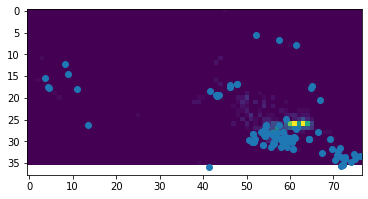

In [136]:
plt.imshow(density[:,:,15].T)
plt.scatter(idata[0]-origin[0],idata[1]-origin[1])

In [120]:
(density[density>0]).min(),density.max()

(1.0, 57.0)

(array([804.,  82.,  33.,   9.,   6.,   4.,   1.,   4.,   1.,   1.]),
 array([ 2. ,  7.5, 13. , 18.5, 24. , 29.5, 35. , 40.5, 46. , 51.5, 57. ]),
 <BarContainer object of 10 artists>)

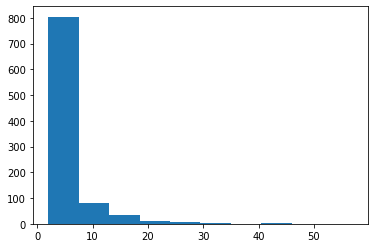

In [123]:
pt = density[density>1]
plt.hist(pt.flatten())